## 🔎 Exploring Advanced Models for COVID-19 Mortality


Building on our initial multiple linear regression (MLR) analysis, this notebook employs more advanced modeling techniques to better understand the relationship between long-term PM₂.₅ exposure, socio-demographic development (SDI), and COVID-19 mortality across countries. We leverage machine learning methods (Random Forest), nonlinear modeling (splines), interaction analysis, quantile regression, and influential data point detection to capture complex and context-dependent effects. These approaches go beyond traditional linear models, allowing us to uncover nuanced patterns and provide deeper insight into the factors shaping COVID-19 mortality at the country level.


### 📦 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from patsy import dmatrix
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.regression.quantile_regression as qr

### 📁 Dataset Read & Preview

In [2]:
df = pd.read_csv("../1_datasets/final_datasets/final_merged_covid_pm25_sdi.csv")
df.head()

,Country,COVID_Deaths_Rate,upper,lower,Mean_PM25_2010_2019,Year,SDI_mean_value
0,Lao People's Democratic Republic,6.867837e-11,6.867837e-11,6.867837e-11,21.164,2020,0.484193
1,Sri Lanka,2.820345e+00,2.820345e+00,2.820345e+00,23.948,2020,0.697649
2,Fiji,8.084884e+00,1.685940e+01,2.008246e+00,7.272,2020,0.671431
3,Samoa,2.370317e-09,2.370317e-09,2.370317e-09,7.623,2020,0.590075
4,Malaysia,1.516114e+00,2.286782e+00,8.061217e-01,21.670,2020,0.738744


### 🌳 Random Forest Regression for COVID-19 Mortality
We use a Random Forest model to predict the (log-transformed) COVID-19 death rate based on long-term PM₂.₅ exposure and SDI. This approach captures potential nonlinear effects and interactions between predictors.



In [3]:
df["log_death_rate"] = np.log(df["COVID_Deaths_Rate"])

X = df[["Mean_PM25_2010_2019", "SDI_mean_value"]]
y = df["log_death_rate"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=100
)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### 📊 Model Evaluation
We evaluated the Random Forest model’s performance on the test set using R², MAE, and RMSE metrics:  
- **R² = 0.33**: The model explains about 33% of the variance in log COVID-19 death rates.  
- **MAE = 2.79**, **RMSE = 5.18**: The prediction errors indicate moderate accuracy, suggesting that other unmeasured factors likely influence COVID-19 mortality across countries.


In [4]:
y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Model Performance on Test Set:")
print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

Model Performance on Test Set:
R²: 0.329
MAE: 2.788
RMSE: 5.183


### ⭐ Feature Importance
The Random Forest model indicates that both long-term PM₂.₅ exposure and SDI contribute to predicting COVID-19 mortality, with PM₂.₅ having a slightly higher importance (54%) compared to SDI (46%). This suggests that both factors play a meaningful role in explaining cross-country differences in COVID-19 death rates.


In [5]:
importance = pd.DataFrame(
    {"Feature": X.columns, "Importance": rf.feature_importances_}
).sort_values("Importance", ascending=False)

print("Feature Importance:")
print(importance)

Feature Importance:
               Feature  Importance
0  Mean_PM25_2010_2019    0.536289
1       SDI_mean_value    0.463711


### 📉 Partial Dependence Plots
The partial dependence plots show how predicted COVID-19 mortality changes with PM₂.₅ exposure and SDI, holding the other variable constant. The results suggest nonlinear relationships for both predictors, with some sharp changes at certain values. This highlights the value of using a flexible model like Random Forest to capture complex effects that may not be apparent in simple linear analysis.


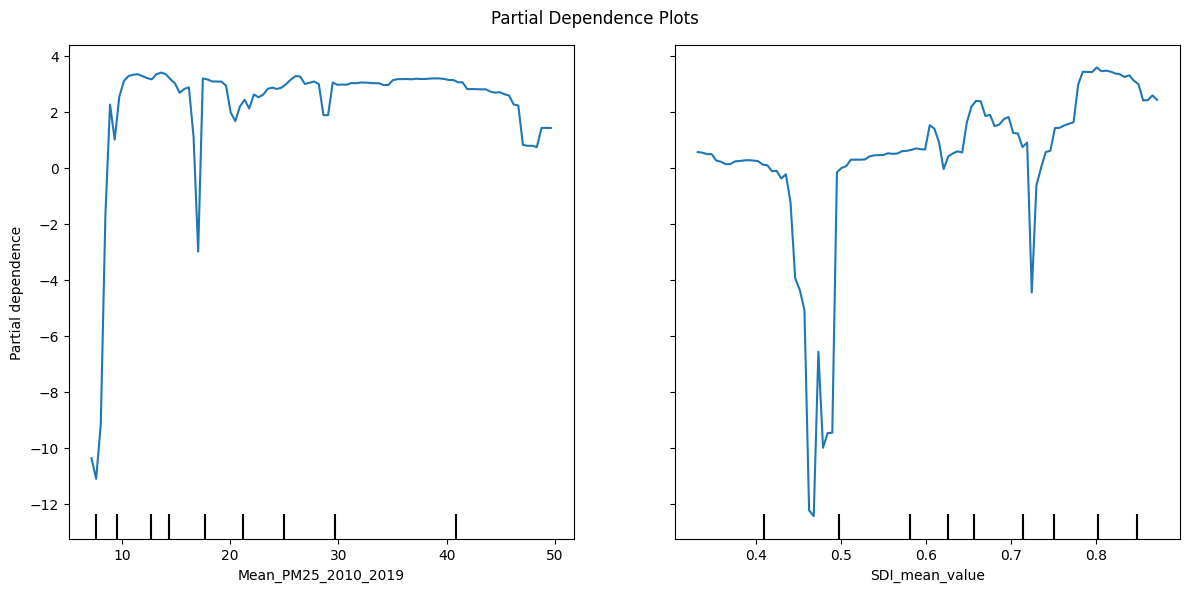

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    rf, X_train, ["Mean_PM25_2010_2019", "SDI_mean_value"], ax=ax
)
plt.suptitle("Partial Dependence Plots")
plt.tight_layout()
plt.show()

### 📈 Spline Regression for Nonlinear Effects
To capture potential nonlinear effects of PM₂.₅ on COVID-19 mortality, we fit an OLS regression using spline terms for PM₂.₅ and included SDI as a covariate.  
**Model Fit:** The model explains about 23% of the variance in log COVID-19 death rates (R² = 0.23).  
**Findings:** Several spline terms for PM₂.₅ are statistically significant, indicating a nonlinear association. SDI shows a positive but only marginally significant effect (p ≈ 0.07).  
**Interpretation:** This approach suggests that the relationship between PM₂.₅ and COVID-19 mortality is not strictly linear, and both factors contribute to explaining cross-country differences.


In [7]:
df["log_death_rate"] = np.log(df["COVID_Deaths_Rate"] + 1)

pm25_spline = dmatrix(
    "bs(Mean_PM25_2010_2019, df=4, include_intercept=False)",
    {"Mean_PM25_2010_2019": df["Mean_PM25_2010_2019"]},
    return_type="dataframe",
)

X = pd.concat([pm25_spline, df["SDI_mean_value"]], axis=1)
X = sm.add_constant(X)
y = df["log_death_rate"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_death_rate   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     10.79
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           4.10e-09
Time:                        11:53:52   Log-Likelihood:                -341.47
No. Observations:                 190   AIC:                             694.9
Df Residuals:                     184   BIC:                             714.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

### 📊 Visualizing the Nonlinear Effect of PM₂.₅
This plot shows the predicted relationship between long-term PM₂.₅ exposure and the log COVID-19 death rate, with uncertainty bands from the spline regression. The curve highlights a nonlinear association: COVID-19 mortality risk rises with PM₂.₅ up to a point, then levels off. The scatter points represent actual country data, illustrating the model fit and variability.


X_pred columns: Index(['Intercept', 'bs(x, df=4, include_intercept=False)[0]',
       'bs(x, df=4, include_intercept=False)[1]',
       'bs(x, df=4, include_intercept=False)[2]',
       'bs(x, df=4, include_intercept=False)[3]', 'SDI_mean_value'],
      dtype='object')
Model params: Index(['Intercept',
       'bs(Mean_PM25_2010_2019, df=4, include_intercept=False)[0]',
       'bs(Mean_PM25_2010_2019, df=4, include_intercept=False)[1]',
       'bs(Mean_PM25_2010_2019, df=4, include_intercept=False)[2]',
       'bs(Mean_PM25_2010_2019, df=4, include_intercept=False)[3]',
       'SDI_mean_value'],
      dtype='object')


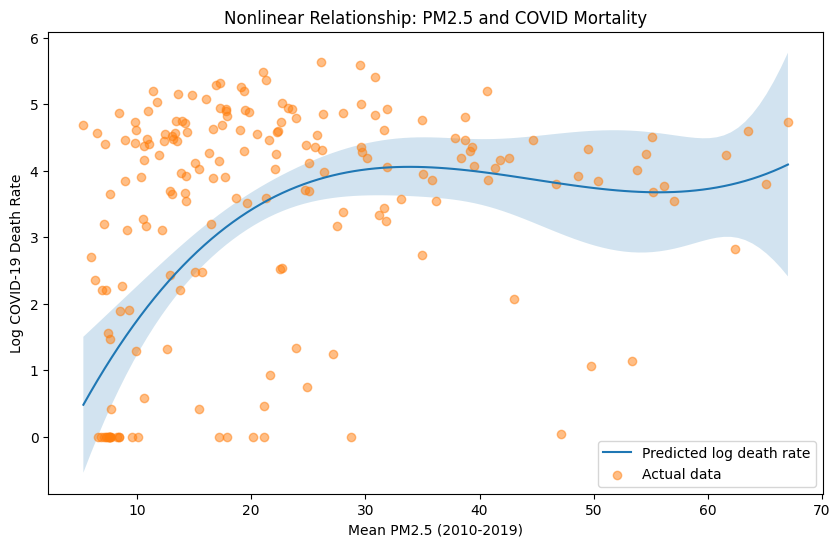

In [8]:
pm25_range = np.linspace(
    df["Mean_PM25_2010_2019"].min(), df["Mean_PM25_2010_2019"].max(), 100
)
pm25_spline = dmatrix(
    "bs(x, df=4, include_intercept=False)", {"x": pm25_range}, return_type="dataframe"
)

X_pred = pd.concat(
    [
        pm25_spline.reset_index(drop=True),
        pd.DataFrame(
            {"SDI_mean_value": df["SDI_mean_value"].median()}, index=range(100)
        ),
    ],
    axis=1,
)

print("X_pred columns:", X_pred.columns)
print("Model params:", model.params.index)

pred = model.get_prediction(X_pred)
pred_summary = pred.summary_frame(alpha=0.05)

pred_df = pd.DataFrame(
    {
        "PM25": pm25_range,
        "Predicted": pred_summary["mean"],
        "CI_low": pred_summary["mean_ci_lower"],
        "CI_high": pred_summary["mean_ci_upper"],
    }
)


# Plot results
plt.figure(figsize=(10, 6))
plt.plot(pred_df["PM25"], pred_df["Predicted"], label="Predicted log death rate")
plt.fill_between(pred_df["PM25"], pred_df["CI_low"], pred_df["CI_high"], alpha=0.2)
plt.scatter(
    df["Mean_PM25_2010_2019"], df["log_death_rate"], alpha=0.5, label="Actual data"
)
plt.xlabel("Mean PM2.5 (2010-2019)")
plt.ylabel("Log COVID-19 Death Rate")
plt.title("Nonlinear Relationship: PM2.5 and COVID Mortality")
plt.legend()
plt.show()

### 🔄 Modeling Interaction: PM₂.₅ and SDI
We extended the spline regression to include an interaction between PM₂.₅ and SDI. This model explains about 31% of the variance in log COVID-19 death rates (R² = 0.31).  
**Findings:** Several interaction terms are statistically significant, indicating that the effect of PM₂.₅ on COVID-19 mortality varies by SDI level.  
**Interpretation:** The relationship between air pollution and COVID-19 mortality is not only nonlinear but also depends on a country’s socio-demographic development, highlighting the importance of considering both factors together.


In [9]:
formula = """
log_death_rate ~ 
bs(Mean_PM25_2010_2019, df=4) * SDI_mean_value
"""
interaction_model = smf.ols(formula, data=df).fit()
print(interaction_model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_death_rate   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     9.132
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           2.42e-11
Time:                        11:53:54   Log-Likelihood:                -330.17
No. Observations:                 190   AIC:                             680.3
Df Residuals:                     180   BIC:                             712.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### PM2.5 vs COVID-19 Mortality by SDI Category

This plot shows the relationship between **average PM2.5 levels (2010–2019)** and **log-transformed COVID-19 death rates (2020)** across countries, grouped by **SDI level**:

- Each point represents a country.
- Lines show smoothed trends (likely spline fits) within each SDI group.

#### Highlights:

- **Very High SDI**: Mortality peaks at moderate PM2.5, then declines.
- **Low/Medium SDI**: Generally increasing or flat mortality trends.
- **High SDI**: Nonlinear trend with a mid-range peak.
- Death rates near zero are clustered at lower PM2.5 levels in less developed countries.

This suggests that the impact of PM2.5 on COVID-19 mortality may depend on development level and healthcare capacity.

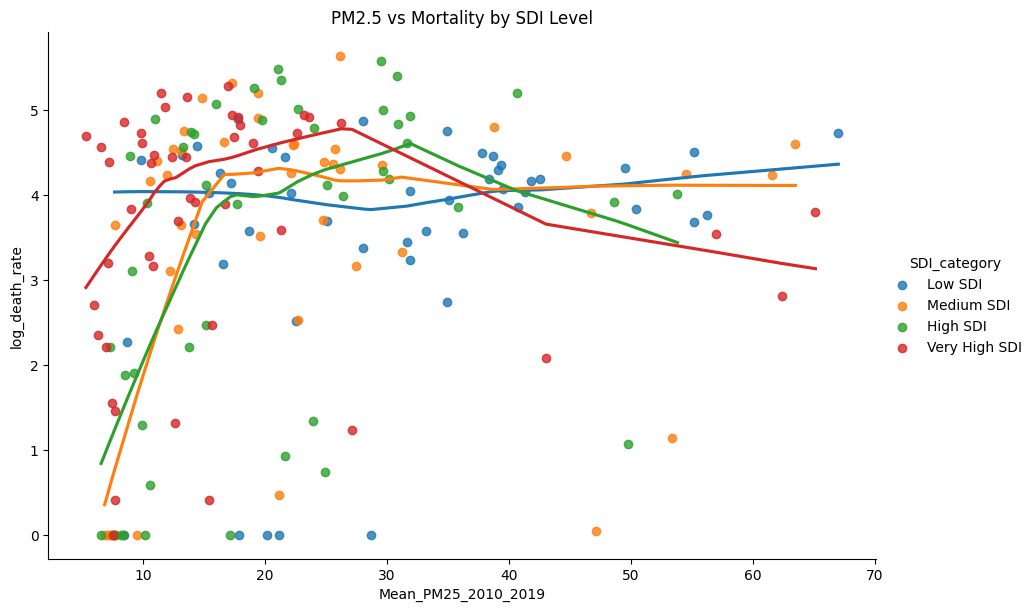

In [15]:
df["SDI_category"] = pd.qcut(
    df["SDI_mean_value"],
    4,
    labels=["Low SDI", "Medium SDI", "High SDI", "Very High SDI"],
)

sns.lmplot(
    x="Mean_PM25_2010_2019",
    y="log_death_rate",
    hue="SDI_category",
    data=df,
    ci=None,
    height=6,
    aspect=1.5,
    lowess=True,  # <--- nonlinear fit
)
plt.title("PM2.5 vs Mortality by SDI Level")
plt.show()

### 🔍 Identifying Influential Data Points
We used Cook’s distance to identify the most influential countries in the regression analysis. The top five influential points include countries with extreme values in COVID-19 death rates, PM₂.₅ exposure, or SDI (e.g., Afghanistan, Bahamas, China, Mongolia, Sweden). These outliers may disproportionately affect model results and warrant further investigation or sensitivity analysis.


In [11]:
infl = OLSInfluence(model)
print("\nTop 5 Influential Points:")

top5_idx = infl.cooks_distance[0].argsort()[-5:]

print(
    df.loc[
        top5_idx,
        ["Country", "COVID_Deaths_Rate", "Mean_PM25_2010_2019", "SDI_mean_value"],
    ]
)


Top 5 Influential Points:
        Country  COVID_Deaths_Rate  Mean_PM25_2010_2019  SDI_mean_value
33        China           1.898881               49.782        0.713365
73       Sweden          95.284529                6.532        0.885062
17     Mongolia           0.040810               47.101        0.614630
97  Afghanistan         112.969944               67.013        0.329830
50      Bahamas         108.036867                5.306        0.802948


### 📐 Quantile Regression Analysis
To explore how predictors affect different parts of the COVID-19 mortality distribution, we ran quantile regressions at the 25th, 50th, and 75th percentiles.  
**Findings:**  
- At the 25th percentile, higher PM₂.₅ is significantly associated with increased COVID-19 mortality, while SDI is not significant.  
- At the median (50th percentile), the associations are weaker and not statistically significant.  

This suggests that PM₂.₅ may have a stronger effect in countries with lower COVID-19 mortality rates, while the relationship is less clear at higher quantiles.  
Quantile regression provides a more nuanced view than mean-based models, revealing that the impact of air pollution may differ across the mortality distribution.


In [12]:
for quantile in [0.25, 0.5, 0.75]:
    q_model = qr.QuantReg(
        df["log_death_rate"],
        sm.add_constant(df[["Mean_PM25_2010_2019", "SDI_mean_value"]]),
    ).fit(q=quantile)
    print(f"\nQuantile {quantile} Results:")
    print(q_model.summary())


Quantile 0.25 Results:
                         QuantReg Regression Results                          
Dep. Variable:         log_death_rate   Pseudo R-squared:              0.08158
Model:                       QuantReg   Bandwidth:                       1.283
Method:                 Least Squares   Sparsity:                        6.555
Date:                Wed, 16 Jul 2025   No. Observations:                  190
Time:                        11:53:59   Df Residuals:                      187
                                        Df Model:                            2
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.4607      1.151      2.139      0.034       0.191       4.731
Mean_PM25_2010_2019     0.0404      0.019      2.117      0.036       0.003       0.078
SDI_mean_value         -1.3102      1.321     -0.992      0.323      -3

# 📊 Discussion & Conclusion

In this notebook, we used statistical and machine learning models to explore how long-term PM₂.₅ exposure and socio-demographic development (SDI) relate to COVID-19 mortality across countries.

---

### Key Insights

**Random Forest Modeling**  
Both PM₂.₅ and SDI emerged as important predictors of COVID-19 mortality, with PM₂.₅ showing slightly higher importance. Still, the model explained only a moderate share of the variance, highlighting the role of other unmeasured factors.

**Nonlinear and Interaction Effects**  
Spline regression revealed a nonlinear relationship between PM₂.₅ and mortality, and interaction models showed that the impact of air pollution varies depending on SDI level.

**Influential Data Points**  
Countries with extreme values had a noticeable influence on the models, emphasizing the importance of cautious interpretation.

**Quantile Regression**  
The association between PM₂.₅ and COVID-19 mortality was stronger at lower quantiles, suggesting air pollution may matter more in countries with relatively lower death rates.

---

### Limitations and Context

- The analysis does not include key factors such as healthcare capacity, age distribution, comorbidities, or policy responses.  
- Early waves of COVID-19 heavily affected higher-SDI countries, which may confound the observed relationships. Differences in testing, reporting, and pandemic timing across countries also add complexity.  
- Using country-level data may overlook significant within-country variation.

---

### Conclusion

This analysis shows that long-term air pollution and socio-demographic development are linked to COVID-19 mortality in complex and context-dependent ways. While our models highlight these associations, they must be interpreted in light of unmeasured confounders and the unique dynamics of the pandemic. These findings stand as the final summary of our exploration.
